### Imports and Helper

In [1]:
import pandas as pd
import librosa as lr
import librosa.display as lrd
import time
import warnings
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
from torch import Tensor
import torch
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.optim import Adam, SGD
from torch.utils.data import Dataset
import math
import datetime

In [ ]:
!wget http://cvml.unige.ch/databases/DEAM/DEAM_Annotations.zip

In [ ]:
!wget http://cvml.unige.ch/databases/DEAM/DEAM_audio.zip


In [ ]:
!unzip DEAM_audio.zip

In [ ]:
!unzip DEAM_Annotations.zip

# Dataset

In [16]:
from librosa import util
from joblib import Parallel, delayed
from tqdm import tqdm

In [18]:
import pandas as pd
from tqdm import tqdm
import numpy as np
from joblib import Parallel, delayed
from torch.utils.data import Dataset
import torch
import librosa as lr
import warnings


class WindowedAudioDataset(Dataset):
    """

    """
    def __init__(self, arousal_file, valence_file, audio_dir,
                 window_length=20.0, window_hopsize=15.0,
                 sampling_rate=44100, max_length=45.0, mfcc_features=30,
                 feature_hop_len=1764, feature_window_size=4410,
                 sequence_annotation=True):
        """

        :param arousal_file:
        :param valence_file:
        :param audio_dir:
        :param window_length:
        :param window_hopsize:
        :param sampling_rate:
        :param max_length:
        :param mfcc_features:
        :param feature_hop_len:
        :param feature_window_size:
        :param sequence_annotation:
        """
        self.mfcc_features = mfcc_features
        self.audio_dir = audio_dir
        self.sr = sampling_rate
        self.max_length = max_length
        self.arousal_file = pd.read_csv(arousal_file)
        self.valence_file = pd.read_csv(valence_file)
        self.window_length = window_length
        self.annotation_start = 15.0
        self.annotation_end = 44.0
        self.feature_hop_len = feature_hop_len
        self.window_hopsize = window_hopsize
        self.feature_window_size = feature_window_size
        self.mfccs = []
        self.tempograms = []
        self.energies = []
        self.sequence_annotation = sequence_annotation

        # self.target_transform = target_transform
        # self.transform = transform

        self.mode = 'mfcc'

    def generate_x_y(self, worker: int = 16):
        self.file_names = []
        self.labels = []
        print('Retrieving File Names and Labels...')
        max_range = (self.annotation_end - self.window_length / 2) * 1000 + 1

        if self.sequence_annotation:
            for i, row in tqdm(self.valence_file.iterrows()):
                self.file_names.append(str(int(row['song_id'])) + '.mp3')
                max_range -= 1
                for start_index in range(int(self.annotation_start * 1000), int((self.annotation_end-self.window_length) * 1000),
                                         int(self.window_hopsize * 1000)):
                    label = []
                    for point in range(start_index, int(start_index + self.window_length * 1000), 500):
                        label_name = 'sample_' + str(point) + 'ms'
                        label.append([row[label_name], self.arousal_file.iloc[i].loc[label_name]])

                    self.labels.append(label)

        else:
            for i, row in tqdm(self.valence_file.iterrows()):
                self.file_names.append(str(int(row['song_id'])) + '.mp3')

                for label_index in range(int(self.annotation_start * 1000), int(max_range),
                                         int(self.window_hopsize * 1000)):
                    label_name = 'sample_' + str(label_index) + 'ms'
                    self.labels.append([row[label_name], self.arousal_file.iloc[i].loc[label_name]])

        self.labels = np.array(self.labels)
        print('Done!')

        print('Loading Files and Features...')
        print(f'Using {worker} Threads')
        warnings.filterwarnings('ignore', '.*audioread.*')
        # self.samples = []

        n_per_second = int(self.sr / self.feature_hop_len)
        self.mfccs = []
        self.tempograms = []
        self.energies = []

        res = Parallel(n_jobs=worker, backend='multiprocessing')(
            delayed(self.load_sample)(f) for f in tqdm(self.file_names))

        if self.sequence_annotation:
            for i in tqdm(range(len(self.file_names))):
                for start_index in range(int(self.annotation_start), int(self.annotation_end-self.window_length), int(self.window_hopsize)):
                    start = int(start_index * n_per_second)
                    end = int((start_index + self.window_length) * n_per_second)
                    self.mfccs.append(res[i][0][start:end])
                    self.energies.append(res[i][1][start:end])
                    self.tempograms.append(res[i][2][start:end])
        else:
            range_max = int(self.annotation_end - self.window_length / 2)
            for i in tqdm(range(len(self.file_names))):
                for ii in range(int(self.annotation_start), range_max, int(self.window_hopsize)):
                    start = int((ii - self.window_length / 2) * n_per_second)
                    end = int((ii + self.window_length / 2) * n_per_second)
                    self.mfccs.append(res[i][0][start:end])
                    self.energies.append(res[i][1][start:end])
                    self.tempograms.append(res[i][2][start:end])

        self.mfccs = np.array(self.mfccs)
        self.tempograms = np.array(self.tempograms)
        self.energies = np.array(self.energies)
        # self.samples = np.array(self.samples)
        print('Done!')
        del res

    def load_sample(self, file_name):
        # DEAM Dataset includes only Audio Files with 44100Hz as native sr
        sample = lr.load(self.audio_dir + file_name, sr=self.sr,
                         duration=self.max_length)[0]

        # self.samples.append(sample)
        S = lr.stft(y=sample, n_fft=self.feature_window_size, hop_length=self.feature_hop_len)
        energy = \
        lr.feature.rms(S=lr.magphase(S)[0], frame_length=self.feature_window_size, hop_length=self.feature_hop_len)[0]

        tempogram = lr.feature.tempogram(y=sample, sr=self.sr, hop_length=self.feature_hop_len).transpose()

        mfcc = lr.feature.mfcc(S=lr.power_to_db(lr.feature.melspectrogram(S=np.square(np.abs(S)), sr=self.sr)),
                               sr=self.sr,
                               n_mfcc=self.mfcc_features, ).transpose()
        return mfcc, energy, tempogram

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        if self.mode == 'mfcc':
            return torch.Tensor(self.mfccs[idx].transpose()), torch.Tensor(self.labels[idx])
        elif self.mode == 'energy-tempo':
            return [torch.Tensor(self.energies[idx]), torch.Tensor(self.tempograms[idx])], torch.Tensor(
                self.labels[idx])
        elif self.mode == 'all':
            return [torch.Tensor(self.mfccs[idx].transpose()), torch.Tensor(self.energies[idx]),
                    torch.Tensor(self.tempograms[idx])], torch.Tensor(self.labels[idx])
        elif self.mode == 'mfcc_last_sequence':
            return[torch.Tensor(self.mfccs[idx].transpose()), torch.Tensor(self.labels[idx, -1])]


In [12]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [19]:
lr.__version__

'0.8.1'

In [20]:
audio_base_path = 'MEMD_audio/'
arousal_file = 'annotations/annotations averaged per song/dynamic (per second annotations)/arousal.csv'
valence_file = 'annotations/annotations averaged per song/dynamic (per second annotations)/valence.csv'
dataset_path = 'dataset.torchdata'

In [21]:

deam_dataset = WindowedAudioDataset(arousal_file,
                                    valence_file,
                                    audio_base_path,
                                    window_length=15.0,
                                    window_hopsize=10.0,
                                    mfcc_features=30,
                                    feature_hop_len=4410,
                                    feature_window_size=4410,
                                    sequence_annotation=False
                                    )

In [22]:
deam_dataset.generate_x_y()

Retrieving File Names and Labels...


1802it [00:03, 550.80it/s]


Done!
Loading Files and Features...
Using 16 Threads


100%|██████████| 1802/1802 [00:00<00:00, 102390.18it/s]


Done!


In [ ]:
#torch.save(deam_dataset, dataset_path, pickle_protocol=4)

In [23]:
deam_dataset.mode = 'mfcc'

In [24]:
test = deam_dataset[0]
print(test[0].size())
print(test[1].size())

torch.Size([30, 150])
torch.Size([2])


# Model

In [31]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Subset
from torch.utils.data.sampler import SubsetRandomSampler
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [26]:
batch_size = 128
validation_split = .2
shuffle_dataset = True
random_seed = 42345

dataset_size = len(deam_dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset:
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(deam_dataset, batch_size=batch_size,
                                           sampler=train_sampler)
validation_loader = torch.utils.data.DataLoader(deam_dataset, batch_size=batch_size,
                                                sampler=valid_sampler)


In [168]:
class MFCCNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.C1 = nn.Conv2d(1, 16, (4, 10), padding=1)
        self.C2 = nn.Conv2d(16, 32, 4, padding=1)
        self.C3 = nn.Conv2d(32, 32, 4, padding=1)
        self.C4 = nn.Conv2d(32, 64, 4, padding=1)
        
        self.BN1 = nn.BatchNorm2d(16)
        self.BN2 = nn.BatchNorm2d(32)
        self.BN3 = nn.BatchNorm2d(64)
        self.maxpool1 = nn.MaxPool2d((2,4),2)
        self.maxpool2 = nn.MaxPool2d((2,4),(1,2))
        
        self.fc1 = nn.Linear(1920,128)

        self.fc2 = nn.Linear(128,2)
        self.dropout = nn.Dropout(0.25)
        self.Bat1 = nn.BatchNorm1d(128)

    def forward(self, x):
        x = x[:, None, :, :]
        x = F.relu(self.BN1(self.C1(x)))
        x = self.maxpool1(F.relu(self.BN2(self.C2(x))))
        x = self.maxpool1(F.relu(self.BN2(self.C3(x))))
        x = self.maxpool1(F.relu(self.BN3(self.C4(x))))
        # flatten image input
        x = self.dropout(x.view(-1,1920))
        # add dropout layer
        x = F.relu(self.dropout(self.fc1(x)))
        
        x = self.fc2(x)
        return x


In [187]:
net = MFCCNet().to(device)

In [188]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.0001)

In [189]:
testf = torch.Tensor(test[0]).to(device)[None, :, :]
print(testf.size())

torch.Size([1, 30, 150])


In [190]:
net(testf)

tensor([[0.0886, 0.1613]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [191]:
from sklearn.metrics import r2_score

In [192]:
val_loss = []
train_loss = []

for epoch in tqdm(range(50)):

    with torch.set_grad_enabled(False):
        sum = 0.0
        sum_r2 = 0.0
        for test_batch, test_y in validation_loader:
            pred = net(test_batch.to(device))
            loss = criterion(pred, test_y.to(device))
            sum_r2 += r2_score(test_y.cpu(), pred.cpu())
            sum += loss.item()
        val_loss.append([float(epoch), sum / len(validation_loader), sum_r2 / len(validation_loader)])

    i = 0
    for local_batch, local_labels in train_loader:
        optimizer.zero_grad()

        # prediction for training and validation set
        pred = net(local_batch.to(device))
        # computing the training and validation loss
        loss_train = criterion(pred, local_labels.to(device))
        loss_train.backward()
        optimizer.step()

        i += 1
        train_loss.append([float(epoch + i/len(train_loader)), loss_train.item()])

100%|██████████| 50/50 [00:56<00:00,  1.12s/it]


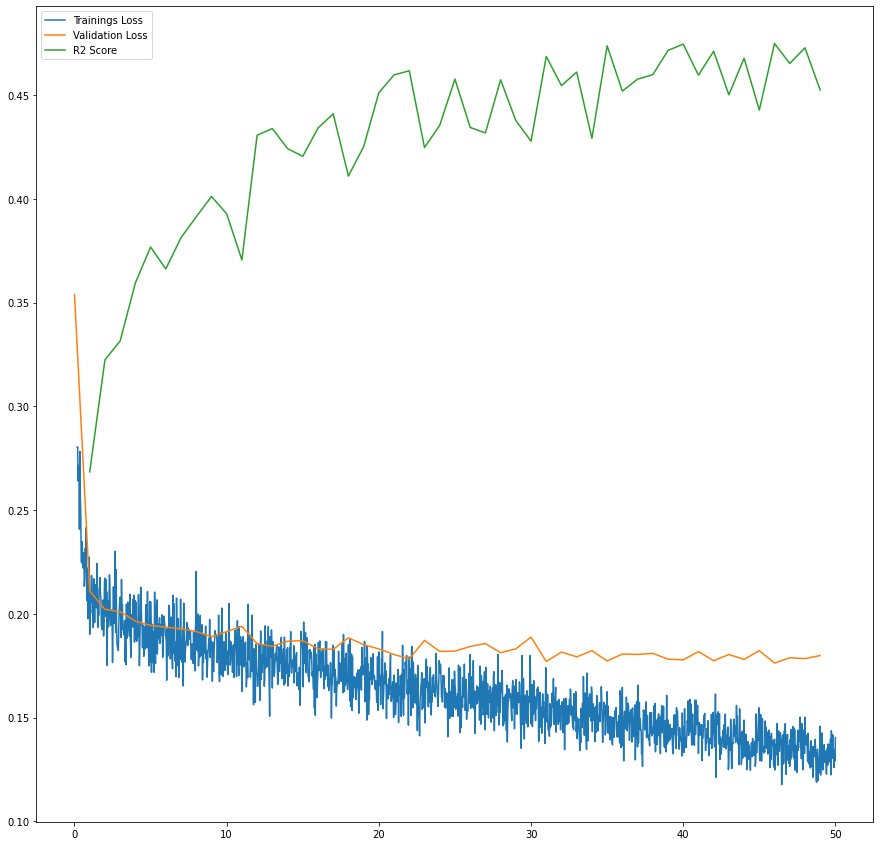

In [193]:
val_loss = np.array(val_loss)
train_loss = np.array(train_loss)

fig, ax = plt.subplots(figsize=(15,15))
ax.plot(train_loss[5:, 0], np.sqrt(train_loss[5:, 1]), label='Trainings Loss')
ax.plot(val_loss[:, 0], np.sqrt(val_loss[:, 1]), label='Validation Loss')
ax.plot(val_loss[1:, 0], val_loss[1:, 2], label='R2 Score')
ax.legend()

In [194]:
np.sqrt(val_loss[-1, 1])

0.17989139000287374